In this notebook we demo a situation where chaotic gradients emerge. 

This is the same setup as used in figure 3 of https://arxiv.org/abs/2111.05803.

In [1]:
!pip install git+https://github.com/google/learned_optimization.git

  Cloning https://github.com/google/learned_optimization.git to /tmp/pip-req-build-q4w2_84g
  Running command git clone -q https://github.com/google/learned_optimization.git /tmp/pip-req-build-q4w2_84g
     |████████████████████████████████| 129 kB 5.1 MB/s 
     |████████████████████████████████| 154 kB 35.7 MB/s 
     |████████████████████████████████| 3.8 MB 53.7 MB/s 
     |████████████████████████████████| 179 kB 69.5 MB/s 
     |████████████████████████████████| 287 kB 67.5 MB/s 
     |████████████████████████████████| 136 kB 76.4 MB/s 
     |████████████████████████████████| 4.2 MB 51.1 MB/s 
     |████████████████████████████████| 48 kB 6.5 MB/s 
     |████████████████████████████████| 70 kB 8.8 MB/s 
     |████████████████████████████████| 462 kB 67.6 MB/s 
  Created wheel for learned-optimization: filename=learned_optimization-0.0.1-py3-none-any.whl size=283072 sha256=512835052c7bed08f5e617723587ec6c301d17515268c52200f03ce0bd065581
  Stored in directory: /tmp/pip-ephem-wheel-

In [2]:
import seaborn as sns
import numpy as onp
import matplotlib.pyplot as plt
import functools


In [3]:
import numpy as np
import jax.numpy as jnp
import jax
from matplotlib import pylab as plt

from learned_optimization.outer_trainers import full_es
from learned_optimization.outer_trainers import truncated_pes
from learned_optimization.outer_trainers import gradient_learner
from learned_optimization.outer_trainers import truncation_schedule

from learned_optimization.tasks import quadratics
from learned_optimization.tasks.fixed import image_mlp
from learned_optimization.tasks import base as tasks_base
from learned_optimization.tasks.datasets import base as datasets_base
from learned_optimization.tasks.datasets import image

from learned_optimization.learned_optimizers import base as lopt_base
from learned_optimization.learned_optimizers import mlp_lopt
from learned_optimization.optimizers import base as opt_base

from learned_optimization import optimizers
from learned_optimization import eval_training

import haiku as hk
import tqdm

ERROR:absl:Oryx not found! This library will still work but no summarywill be logged.


In [4]:
class LogMnistRelu32x32(tasks_base.Task):
  def __init__(self):
  
    def _forward(inp):
      inp = jnp.reshape(inp, [inp.shape[0], -1])
      return hk.nets.MLP([32, 32, 10])(inp)
  
    self.net = hk.without_apply_rng(hk.transform(_forward))

    batch_size = 128
    self.datasets = image.mnist_datasets(batch_size)

  def init(self, rng):
    batch = next(self.datasets.train)
    return self.net.init(rng, batch["image"])

  def loss(self, params, rng, data):
    image = data["image"]
    logits = self.net.apply(params, image)
    labels = jax.nn.one_hot(data["label"], 10)
    vec_loss = tasks_base.softmax_cross_entropy(logits=logits, labels=labels)
    return jnp.log(jnp.mean(vec_loss))


In [5]:
#task = image_mlp.ImageMLP_FashionMnist8_Relu32()
task = LogMnistRelu32x32()
key = jax.random.PRNGKey(0)


lopt = mlp_lopt.MLPLOpt()
params = lopt.init(key)


data = next(task.datasets.train)

@functools.partial(jax.jit, static_argnames=("steps", "add_noise"))
def eval_reward(params, rng, steps=100, add_noise=True):
  if add_noise:
    flat_p, struct = jax.tree_flatten(params)
    outs = []
    for i,p in enumerate(flat_p):
      rng, key1 = jax.random.split(rng)
      outs.append(jax.random.normal(key1, shape=p.shape) * 0.01 + p)
    params = struct.unflatten(outs)

  p = task.init(key)

  opt = lopt.opt_fn(params)
  opt_state = opt.init(p, num_steps=10000)

  @jax.checkpoint
  def advance_state(opt_state, i):
    p = opt.get_params(opt_state)
    key1 = jax.random.fold_in(rng, i)
    key1, key2 = jax.random.split(key1)
    loss, grad = jax.value_and_grad(task.loss)(p, key1, data)
    opt_state = opt.update(opt_state, loss=loss, grad=grad, key=key2)
    return opt_state, loss
  
  final_state, rews = jax.lax.scan(advance_state, opt_state, jnp.arange(steps))
  return jnp.mean(rews)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
jax.tree_map(lambda x: x.shape, params)

FlatMap({
  'mlp/~/linear_0': FlatMap({'b': (32,), 'w': (19, 32)}),
  'mlp/~/linear_1': FlatMap({'b': (32,), 'w': (32, 32)}),
  'mlp/~/linear_2': FlatMap({'b': (2,), 'w': (32, 2)}),
})

In [7]:
jv_eval_reward = jax.jit(jax.vmap(eval_reward, in_axes=[None, 0]))
v_key = jax.random.split(jax.random.PRNGKey(0), 128)
# out = jv_eval_reward(params, v_key)

In [8]:
def interpolate_loss(params, direction, key, steps, ts):
  params = jax.tree_map(lambda x, d: x+d*ts, params, direction)
  return eval_reward(params, key, steps=steps)

@functools.partial(jax.jit, static_argnames=("steps",))
def vmap_interp(params, direction, ts, key, steps=10):
  #return jax.vmap(jax.partial(interpolate_loss, steps=steps), in_axes=(None, None, 0, None))(params, direction, ts, key)
  #return jax.vmap(jax.partial(interpolate_loss, steps=steps,), in_axes=(None, None, 0, None))(params, direction, ts, key)
  fn = functools.partial(interpolate_loss, params, direction, key, steps)
  # return jax.lax.map(fn, ts)
  ts = jnp.reshape(ts, [-1, 16])
  out = jax.lax.map(jax.vmap(fn), ts)
  return jnp.reshape(out, [-1])

# key = jax.random.PRNGKey(0)
# out = vmap_interp(params, params, jnp.linspace(-0.01, 0.01, 1280), key)
# print(out.shape)
# out.block_host_until_ready()

In [9]:
def interpolate_grad_along_direction(params, direction, key, steps, ts):
  def fn(ts):
    p= jax.tree_map(lambda x, d: x+d*ts, params, direction)
    return eval_reward(p, key, steps=steps)
  return jax.grad(fn)(ts)


@functools.partial(jax.jit, static_argnames=("steps",))
def vmap_interp_grad(params, direction, ts, key, steps=10):
  #return jax.vmap(jax.partial(interpolate_grad_along_direction, steps=steps), in_axes=(None, None, 0, None))(params, direction, ts, key)
  fn = functools.partial(interpolate_grad_along_direction, params, direction, key, steps)
  return jax.lax.map(fn, ts)
  #return jax.vmap(, in_axes=(None, None, 0, None))(params, direction, ts, key)

# key = jax.random.PRNGKey(0)
# out = vmap_interp_grad(params, params, jnp.linspace(-0.01, 0.01, 10), key)

In [10]:
@functools.partial(jax.jit, static_argnames=("steps", "add_noise"))
def jvg_eval_reward(params, keys, steps=5, add_noise=True):
  return jax.vmap(jax.grad(functools.partial(eval_reward, steps=steps, add_noise=add_noise),
                           0), in_axes=[None, 0])(params, keys)

keys = jax.random.split(jax.random.PRNGKey(0), 16)
#grads = jvg_eval_reward(params, keys)

In [11]:
def tree_normalize(xx):
  sum_squares = sum(jax.tree_leaves(jax.tree_map(lambda x: jnp.sum(jnp.square(x)), xx)))
  sum_params = sum(jax.tree_leaves(jax.tree_map(lambda x: onp.prod(x.shape), xx)))
  norm = jnp.sqrt(sum_squares) / sum_params
  return jax.tree_map(lambda x: x/norm, xx)


In [12]:
onp.random.seed(189)

key = jax.random.PRNGKey(0)
params = lopt.init(jax.random.PRNGKey(2))

onp.random.seed(21)
rand = jax.tree_map(lambda x: onp.random.normal(size=x.shape), params)
direction = tree_normalize(rand)

In [13]:
xs = jnp.linspace(-0.01, 0.01, 1024)
#xs = jnp.linspace(-0.01, 0.01, 128)
#steps = [8, 32, 128, 256, 512, 1024]
steps = [128,]
k = 1
key = jax.random.PRNGKey(k)
first_outs = []
for si, step in enumerate(steps):
  print(step)
  out = vmap_interp(params, direction, xs, key, steps=step)
  out = onp.asarray(out)
  first_outs.append(out)


128


(-2.5, 8.0)

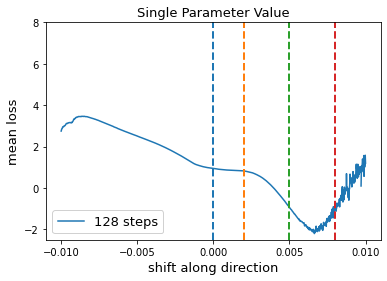

In [14]:
xs = jnp.linspace(-0.01, 0.01, 1024)
#steps = [8, 32, 128]#, 256]#, 512, 1024]
steps = [128]

cat_color = sns.palettes.color_palette(n_colors=10)
colors = sns.palettes.color_palette(n_colors=10)

fig, ax = plt.subplots(figsize=(6, 4))
for si, step in enumerate(steps):
  out = first_outs[si]
  ax.plot(xs, out, label=f"{step} steps", color=colors[si], zorder=10-si-100)
  #ax.semilogy(xs, out, label=f"{step} steps", color=colors[si], zorder=10-si)

ax.legend(loc="lower left", fontsize=13, framealpha=0.9)
ax.set_xlabel("shift along direction", fontsize=13)
ax.set_ylabel("mean loss", fontsize=13)
ax.set_title("Single Parameter Value", fontsize=13)

#ax.set_ylim(0.5, 5.0)
ax.axvline(x=0.0, color=cat_color[0], linestyle="--", lw=2)
ax.axvline(x=0.002, color=cat_color[1], linestyle="--", lw=2)
ax.axvline(x=0.005, color=cat_color[2], linestyle="--", lw=2)
ax.axvline(x=0.008, color=cat_color[3], linestyle="--", lw=2)
ax.set_xticks([-0.01, -0.005, 0.0, 0.005, 0.01])
ax.set_ylim(-2.5, 8)